# Search: Solving a Maze Using a Goal-based Agent


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation,
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root noteto the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [1]:
f = open("small_maze.txt", "r")
maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX


__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the file [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. I represent a position as a 2-tuple of the form `(row, col)`. 

In [2]:
%run maze_helper.py

maze = parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

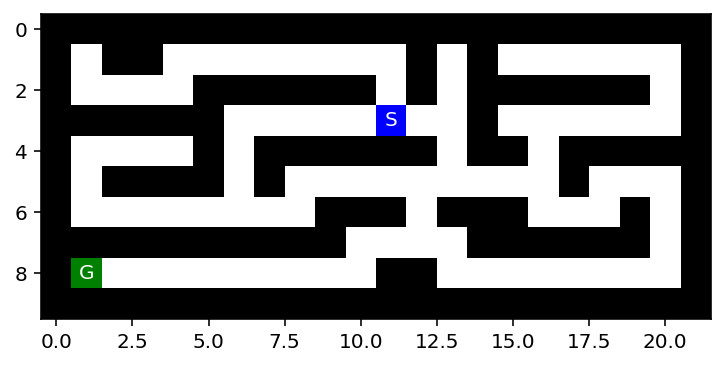

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [4]:
print("Start location:", find_pos(maze, what = "S"))
print("Goal location:", find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [5]:
class Node:
    def __init__(self, pos, parent, action, cost, distance):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search
        self.distance = distance
        
    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)

If needed, then you can add more fields to the class.


__Tree and memory management example:__ Create the root node and append the node for going east with a cost of 1.

In [6]:
# import sys to access reference counts
import sys

print("Create root node")
root = Node(pos = (0,0), parent = None, action = None, cost = 0, distance = 0)
print("root:", root)
print("root (reference):", repr(root))

print()
print("Go east with cost 1 (from the parent root)")
node2 = Node(pos = (0,1), parent = root, action = "E", cost = 1, distance = 0)
print("node2:", node2)
print("parent of node2: ", node2.parent)
print("parent of node2 (reference): ", repr(node2.parent))
# Note: -1 is used because passing root to getrefcount adds one reference
print("Root is now referenced twice. Reference count for garbage collection (root node):", sys.getrefcount(root)-1)

print()
print("Note that the root node is safe from garbage collection as long as we have also a reference in node2") 
root = None
print(root)
print("parent of node2 (reference to root node): ", repr(node2.parent))
print("Reference count for garbage collection (root node):", sys.getrefcount(node2.parent)-1)

print()
print("Path from root to node2")
path = node2.get_path_from_root()
print("References:", path)
print("Positions:", [n.pos for n in path])
print("Actions:", [n.action for n in path])
print("Cost:", [n.cost for n in path])


print()
print("Once we delete the reference to node2, the reference count for all nodes goes to zero and the whole tree is exposed to garbage collection.")
node2 = None



Create root node
root: Node - pos = (0, 0); action = None; cost = 0
root (reference): <__main__.Node object at 0x7f0505a2be80>

Go east with cost 1 (from the parent root)
node2: Node - pos = (0, 1); action = E; cost = 1
parent of node2:  Node - pos = (0, 0); action = None; cost = 0
parent of node2 (reference):  <__main__.Node object at 0x7f0505a2be80>
Root is now referenced twice. Reference count for garbage collection (root node): 2

Note that the root node is safe from garbage collection as long as we have also a reference in node2
None
parent of node2 (reference to root node):  <__main__.Node object at 0x7f0505a2be80>
Reference count for garbage collection (root node): 1

Path from root to node2
References: [<__main__.Node object at 0x7f0505a2be80>, <__main__.Node object at 0x7f0505768ca0>]
Positions: [(0, 0), (0, 1)]
Actions: [None, 'E']
Cost: [0, 1]

Once we delete the reference to node2, the reference count for all nodes goes to zero and the whole tree is exposed to garbage colle

# Goal
Implement the following search algorithms for solving different mazes:

* Breadth-first search (BFS)
* Depth-first search (DFS)
* Greedy best-first search (GBFS)
* A* search

Run each of the above algorithms on the 
[small maze](small_maze.txt), 
[medium maze](medium_maze.txt), 
[large maze](large_maze.txt), 
[open maze](open_maze.txt),
[wall maze](wall_maze.txt),
[loops maze](loops_maze.txt),
[empty maze](empty_maze.txt), and
[empty 2_maze](empty_2_maze.txt).
For each problem instance and each search algorithm, report the following in a table:

* The solution and its path cost
* Number of nodes expanded
* Maximum tree depth
* Maximum size of the frontier

Display each solution by marking every maze square (or state) visited and the squares on the final path.

## Task 1: Defining the search problem and determining the problem size [1 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate. 

*Note:* You can swich the next block from code to Markdown and use formating.

* Initial State: The start location of the algorithm in the maze. A tuple of coordinates
* Actions: The set of possible actions for the function. (North, East, South, West)
* Transition Model: The function that determines the new state from performing an action. 
* Goal State: The Goal location of the algorithm in the maze. A tuple of coordinates
* Path Cost: The sum of nonnegative step costs. Used to evaluate the algorithms

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values from a given maze.

* 𝑛 : state space size: The state space is usually too large or it is continuous. Especially with a maze. First consider the number of available tiles (nxn). Then each tile has 7 possible states. So the static state space for the maze is 7N^2 but when you add a search algorithm with a tree to the state space it becomes too large to quantify.
* 𝑑 : depth of the optimal solution: Is the number of actions needed to reach the goal state. The tree depth or optimal path size from start to goal node. There usually is only one correct optimal solution, unless the maze is symettric or happens to have two optimal paths with the same depth. 
* 𝑚 : maximum depth of tree: Is the number of actions needed in any path, which may be infinite if cycle checks are not implemented. The maximum depth is not always the branch that finds the goal. 
* 𝑏 : maximum branching factor: Number of succesor nodes for a parent. Usually related to the number of intersections the algorithm encounters in the maze.

## Task 2: Uninformed search: Breadth-first and depth-first [4 points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore. 
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DSF is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

In [7]:
#############################################################################################################################################################
#############################################################################################################################################################
#Breadth First Search Code
def BFS(maze, verbose):
    path_cost = 0;
    nodes_expanded = 0;
    max_tree_depth = 0;
    max_tree_size = 0;
    max_frontier = 0; 
    start = find_pos(maze, what = "S")
    goal = find_pos(maze, what = "G")
    node = Node(pos = find_pos(maze, what = "S"), parent = None, action = None, cost = 0, distance = 0)
    if (node.pos == find_pos(maze, what = "G")): return node
    frontier = []
    reached = []
    frontier.append(node)
    
    while(frontier):
        n = frontier.pop(0)
        for child in ExpandBFS(maze, n):
            maze[start] = "S"
            maze[goal] = "G"
            if(verbose): PrintMaze(maze)           
            if (child.pos == goal):
                nodes_expanded = np.count_nonzero(maze == ".")
                path = child.get_path_from_root()
                for node in path:
                    maze[node.pos[0], node.pos[1]] = "P"
                    path_cost += 1
                tree = getMaxTreeDepthBFS(frontier)
                max_tree_depth = tree[0]
                max_tree_size = tree[1]
                maze[start] = "S"
                maze[goal] = "G"
                result = [path_cost, nodes_expanded, max_tree_depth, max_tree_size, max_frontier, n, maze]
                return result         
            if child.pos not in reached:
                reached.append(child.pos)
                frontier.append(child)  
            if(len(frontier) > max_frontier): max_frontier = len(frontier)
    return "Failure"
            
def ExpandBFS(maze, node):
    pos = node.pos
    for action in ActionBFS(maze, pos):
        pos1 = ResultBFS(pos, action)
        cost = node.cost + ActionCostBFS(pos, action, pos1)
        maze[pos] = "."
        if(action != "D"):
            maze[pos1] = "F"
        else:
            maze[pos1] = "."
        yield Node(pos1, node, action, cost, distance = 0)
        
def ActionBFS(maze, pos):
    actions = []     
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if((look(maze, (row-1, col)) == " ") or (look(maze, (row-1, col)) == "G")): #north
        actions.append("N")
    if((look(maze, (row, col+1)) == " ") or (look(maze, (row, col+1)) == "G")): #east
        actions.append("E")
    if((look(maze, (row+1, col)) == " ") or (look(maze, (row+1, col)) == "G")): #south
        actions.append("S")
    if((look(maze, (row, col-1)) == " ") or (look(maze, (row, col-1)) == "G")): #west
        actions.append("W")
    if not actions: #List Empty
        actions.append("D")
    return actions

def ResultBFS(pos, action):
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if(action == "N"):
        return (row-1, (col))
    if(action == "E"):
        return (row, col+1)
    if(action == "S"):
        return (row+1, col)
    if(action == "W"):
        return (row, col-1)
    return pos

def ActionCostBFS(pos, action, pos1):
    return 1              

def getMaxTreeDepthBFS(frontier):
    max_tree_depth = 0
    max_tree_size = 0
    for node in frontier:
        path = node.get_path_from_root()
        if(len(path) > max_tree_depth):
            max_tree_depth = len(path)
        max_tree_size += len(node.get_path_from_root())
    return (max_tree_depth, max_tree_size)

#############################################################################################################################################################
#############################################################################################################################################################
#Depth First Search
def DFS(maze, verbose):
    path_cost = 0;
    nodes_expanded = 0;
    max_tree_depth = 0;
    max_tree_size = 0;
    max_frontier = 0; 
    start = find_pos(maze, what = "S")
    goal = find_pos(maze, what = "G")
    node = Node(pos = find_pos(maze, what = "S"), parent = None, action = None, cost = 0, distance = 0)
    if (node.pos == find_pos(maze, what = "G")): return node
    frontier = []
    frontier.append(node)
    cycle = []
    
    while(frontier):
        node = frontier.pop(len(frontier)-1)
        cycle = node.get_path_from_root()
        maze[start] = "S"
        maze[goal] = "G"
        if(verbose): PrintMaze(maze)  
            
        if (node.pos == goal):
            nodes_expanded = np.count_nonzero(maze == ".")
            path = child.get_path_from_root()
            for node in path:
                maze[node.pos[0], node.pos[1]] = "P"
                path_cost += 1
            tree = getMaxTreeDepthDFS(frontier)
            max_tree_depth = tree[0]
            max_tree_size = tree[1]
            maze[start] = "S"
            maze[goal] = "G"
            result = [path_cost, nodes_expanded, max_tree_depth, max_tree_size, max_frontier, node, maze]
            return result
        
        elif (cycle.count(node) < 2):
            for child in ExpandDFS(maze, node):
                if(child.action != "D"):
                    frontier.append(child)
        if(len(frontier) > max_frontier): max_frontier = len(frontier)
    return "Failure"
            
def ExpandDFS(maze, node):
    pos = node.pos
    for action in ActionDFS(maze, pos):
        pos1 = ResultDFS(pos, action)
        cost = node.cost + ActionCostDFS(pos, action, pos1)
        maze[pos] = "."
        if(action != "D"):
            maze[pos1] = "F"
        else:
            maze[pos1] = "."
        yield Node(pos1, node, action, cost, distance = 0)
        
def ActionDFS(maze, pos):
    actions = []     
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if((look(maze, (row-1, col)) == " ") or (look(maze, (row-1, col)) == "G")): #north
        actions.append("N")
    if((look(maze, (row, col+1)) == " ") or (look(maze, (row, col+1)) == "G")): #east
        actions.append("E")
    if((look(maze, (row+1, col)) == " ") or (look(maze, (row+1, col)) == "G")): #south
        actions.append("S")
    if((look(maze, (row, col-1)) == " ") or (look(maze, (row, col-1)) == "G")): #west
        actions.append("W")
    if not actions: #List Empty
        actions.append("D")
        #print("Dead End")
    return actions

def ResultDFS(pos, action):
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if(action == "N"):
        return (row-1, (col))
    if(action == "E"):
        return (row, col+1)
    if(action == "S"):
        return (row+1, col)
    if(action == "W"):
        return (row, col-1)
    return pos

def ActionCostDFS(pos, action, pos1):
    return 1              

def getMaxTreeDepthDFS(frontier):
    max_tree_depth = 0
    max_tree_size = 0
    for node in frontier:
        path = node.get_path_from_root()
        if(len(path) > max_tree_depth):
            max_tree_depth = len(path)
        max_tree_size += len(node.get_path_from_root())
    return (max_tree_depth, max_tree_size)

How does BFS and DFS deal with loops (cycles)?

# Discussion
# Breadth First Search Cycle Check:
BFS uses an list of previously visited positions called reached to prevent a node being added to the search tree that has already been visited. The reached list is checked by the child nodes position before being added to the frontier list. 

# Depth First Search Cycle Check:
DFS has no reached data structure. Instead, the curren nodes path is used as a cycle check. This prevents any loops from occuring in the tree. In my code I count the number of occurrences of the new node in the current nodes path by usingn the provided get_path_from_root() function. If the number of occurences is greater than 1 the new node is ignored. 

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

# Discussion
# Breadth First Search:
* Complete: Yes
* Optimal: Yes
* Time Complexity: O(bd) d = depth optimal solution
* Space Complexity: O(b^d) Space is usually a bigger problem than time
# Depth First Search:
* Complete: Only in finite search spaces. Incomplete in infinite search spaces (with cycles)
* Optimal: No as it returns the first solution it finds
* Time Complexity: O(b^m) time varies largely with chance of finding solution by chance
* Space Complexity: O(bm) If it only stores frontier nodes and current path

## Task 3: Informed search: Implement greedy best-first search and A* search  [4 points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides). 

In [8]:
#############################################################################################################################################################
#############################################################################################################################################################
#Greedy Best First Search

def GBFS(maze, verbose):
    path_cost = 0;
    nodes_expanded = 0;
    max_tree_depth = 0;
    max_tree_size = 0;
    max_frontier = 0; 
    start = find_pos(maze, what = "S")
    goal = find_pos(maze, what = "G")
    node = Node(pos = find_pos(maze, what = "S"), parent = None, action = None, cost = 0, distance = 0)
    if (node.pos == find_pos(maze, what = "G")): return node
    frontier = []
    reached = []
    frontier.append(node)
    reached = {start : node}
    
    while(frontier):
        EuclideanDistanceGBFS(frontier, goal)
        frontier.sort(key=DistanceGBFS)
        n = frontier.pop(0)
        
        if (n.pos == goal):
            nodes_expanded = np.count_nonzero(maze == ".")
            path = n.get_path_from_root()
            for node in path:
                maze[node.pos[0], node.pos[1]] = "P"
                path_cost += 1
            tree = getMaxTreeDepthGBFS(frontier)
            max_tree_depth = tree[0]
            max_tree_size = tree[1]
            maze[start] = "S"
            maze[goal] = "G"
            result = [path_cost, nodes_expanded, max_tree_depth, max_tree_size, max_frontier, n, maze]
            return result
        
        for child in ExpandGBFS(maze, n):
            maze[start] = "S"
            maze[goal] = "G"
            if(verbose): PrintMaze(maze)  
            pos = child.pos
            if ((pos not in reached) or (child.distance < reached[pos].distance) and (child.action != "D")):
                reached[pos] = child
                frontier.append(child)
  
            if(len(frontier) > max_frontier): max_frontier = len(frontier)
    return "Failure"           

def ExpandGBFS(maze, node):
    pos = node.pos
    for action in ActionGBFS(maze, pos):
        pos1 = ResultGBFS(pos, action)
        cost = node.cost + ActionCostGBFS(pos, action, pos1)
        maze[pos] = "."
        if(action != "D"):
            maze[pos1] = "F"
        else:
            maze[pos1] = "."
        yield Node(pos1, node, action, cost, 0)
        
def ActionGBFS(maze, pos):
    actions = []     
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if((look(maze, (row-1, col)) == " ") or (look(maze, (row-1, col)) == "G")): #north
        actions.append("N")
    if((look(maze, (row, col+1)) == " ") or (look(maze, (row, col+1)) == "G")): #east
        actions.append("E")
    if((look(maze, (row+1, col)) == " ") or (look(maze, (row+1, col)) == "G")): #south
        actions.append("S")
    if((look(maze, (row, col-1)) == " ") or (look(maze, (row, col-1)) == "G")): #west
        actions.append("W")
    if not actions: #List Empty
        actions.append("D")
    return actions

def ResultGBFS(pos, action):
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if(action == "N"):
        return (row-1, (col))
    if(action == "E"):
        return (row, col+1)
    if(action == "S"):
        return (row+1, col)
    if(action == "W"):
        return (row, col-1)
    return pos

def ActionCostGBFS(pos, action, pos1):
    return 1              

def getMaxTreeDepthGBFS(frontier):
    max_tree_depth = 0
    max_tree_size = 0
    for node in frontier:
        path = node.get_path_from_root()
        if(len(path) > max_tree_depth):
            max_tree_depth = len(path)
        max_tree_size += len(node.get_path_from_root())
    return (max_tree_depth, max_tree_size)

def EuclideanDistanceGBFS(frontier, goal):
    import math
    tempG = list(goal)
    rowG = tempG[0]
    colG = tempG[1]
    for node in frontier:
        temp = list(node.pos)
        row = temp[0]
        col = temp[1]
        d = math.hypot((rowG - row),(colG - col))
        node.distance = d

def DistanceGBFS(d):
    return d.distance

#############################################################################################################################################################
#############################################################################################################################################################
#A* Search

def Astar(maze, verbose):
    path_cost = 0;
    nodes_expanded = 0;
    max_tree_depth = 0;
    max_tree_size = 0;
    max_frontier = 0; 
    start = find_pos(maze, what = "S")
    goal = find_pos(maze, what = "G")
    node = Node(pos = find_pos(maze, what = "S"), parent = None, action = None, cost = 0, distance = 0)
    if (node.pos == find_pos(maze, what = "G")): return node
    frontier = []
    reached = []
    frontier.append(node)
    reached = {start : node}
    
    while(frontier):
        EuclideanDistanceA(frontier, start, goal)
        frontier.sort(key=DistanceA)
        n = frontier.pop(0)
        
        if (n.pos == goal):
            nodes_expanded = np.count_nonzero(maze == ".")
            path = n.get_path_from_root()
            for node in path:
                maze[node.pos[0], node.pos[1]] = "P"
                path_cost += 1
            tree = getMaxTreeDepthA(frontier)
            max_tree_depth = tree[0]
            max_tree_size = tree[1]
            maze[start] = "S"
            maze[goal] = "G"
            result = [path_cost, nodes_expanded, max_tree_depth, max_tree_size, max_frontier, n, maze]
            return result
        
        for child in ExpandA(maze, n):
            maze[start] = "S"
            maze[goal] = "G"
            if(verbose): PrintMaze(maze)  
            pos = child.pos
            if ((pos not in reached) or (child.distance < reached[pos].distance) and (child.action != "D")):
                reached[pos] = child
                frontier.append(child)
  
            if(len(frontier) > max_frontier): max_frontier = len(frontier)
    return "Failure"          

def ExpandA(maze, node):
    pos = node.pos
    for action in ActionA(maze, pos):
        pos1 = ResultA(pos, action)
        cost = node.cost + ActionCostA(pos, action, pos1)
        maze[pos] = "."
        if(action != "D"):
            maze[pos1] = "F"
        else:
            maze[pos1] = "."
        yield Node(pos1, node, action, cost, 0)
        
def ActionA(maze, pos):
    actions = []     
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if((look(maze, (row-1, col)) == " ") or (look(maze, (row-1, col)) == "G")): #north
        actions.append("N")
    if((look(maze, (row, col+1)) == " ") or (look(maze, (row, col+1)) == "G")): #east
        actions.append("E")
    if((look(maze, (row+1, col)) == " ") or (look(maze, (row+1, col)) == "G")): #south
        actions.append("S")
    if((look(maze, (row, col-1)) == " ") or (look(maze, (row, col-1)) == "G")): #west
        actions.append("W")
    if not actions: #List Empty
        actions.append("D")
    return actions

def ResultA(pos, action):
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if(action == "N"):
        return (row-1, (col))
    if(action == "E"):
        return (row, col+1)
    if(action == "S"):
        return (row+1, col)
    if(action == "W"):
        return (row, col-1)
    return pos

def ActionCostA(pos, action, pos1):
    return 1              

def getMaxTreeDepthA(frontier):
    max_tree_depth = 0
    max_tree_size = 0
    for node in frontier:
        path = node.get_path_from_root()
        if(len(path) > max_tree_depth):
            max_tree_depth = len(path)
        max_tree_size += len(node.get_path_from_root())
    return (max_tree_depth, max_tree_size)

def EuclideanDistanceA(frontier, start, goal):
    import math
    tempG = list(goal)
    rowG = tempG[0]
    colG = tempG[1]
    for node in frontier:
        dStart = 0
        dGoal = 0
        path = node.get_path_from_root()
        for node in path:
            dStart += 1
        tempG = list(node.pos)
        row = tempG[0]
        col = tempG[1]
        dGoal = math.hypot((rowG - row),(colG - col))  
        node.distance = dStart + dGoal

def DistanceA(d):
    return d.distance

Are your implementations complete and optimal? What is the time and space complexity?

# Discussion
# Greedy Best First Search:
* Complete: Yes
* Optimal: No
* Time Complexity: Worst Case O(b^m) Best Case O(bm) depending on h(n) accuracy
* Space Complexity: Worst Case O(b^m) Best Case O(bm)
# A* Search:
* Complete: Yes
* Optimal: Yes
* Time Complexity: Worst Case O(b^m)
* Space Complexity: Worst Case O(b^m)

## Task 4: Comparison and discussion [2 points] 

Run experiments to compare the implemented algorithms and present the results as tables and charts. 

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [9]:
# Add code, table, charts.
#Table Generator BFS/DFS/BFSS/A*
import pandas as pd
mazes = ["empty_2_maze.txt", "empty_maze.txt", "small_maze.txt", "medium_maze.txt", "large_maze.txt", "open_maze.txt", "loops_maze.txt", "wall_maze.txt"]
    
resultsBFS = []
resultsDFS = []
resultsGBFS = []
resultsA = []
resultsAW = []
for maze in mazes:
    verbose = False
    f = open(maze, "r")
    maze_str = f.read()
    maze_master = parse_maze(maze_str)
    #print("BFS: ", maze)
    maze_master = parse_maze(maze_str)
    resultsBFS = BFS(maze_master, verbose)
    #PrintMaze(resultsBFS[5])
    #print("DFS: ", maze)
    maze_master = parse_maze(maze_str)
    resultsDFS = DFS(maze_master, verbose)
    #PrintMaze(resultsDFS[5])
    #print("GBFS: ", maze)
    maze_master = parse_maze(maze_str)
    resultsGBFS = GBFS(maze_master, verbose)
    #PrintMaze(resultsGBFS[5])
    #print("Astar: ", maze)
    maze_master = parse_maze(maze_str)
    resultsA = Astar(maze_master, verbose)
    #PrintMaze(resultsA[5])
    #print("AstarW: ", maze)

    data = [["BFS", resultsBFS[0], resultsBFS[1], resultsBFS[2], resultsBFS[3], resultsBFS[4]],
        ["DFS", resultsDFS[0], resultsDFS[1], resultsDFS[2], resultsDFS[3], resultsDFS[4]],
        ["GBFS", resultsGBFS[0], resultsGBFS[1], resultsGBFS[2], resultsGBFS[3], resultsGBFS[4]],
        ["A", resultsA[0], resultsA[1], resultsA[2], resultsA[3], resultsA[4]]]
    frame = pd.DataFrame(data, columns=["Algorithm", "Path Cost", "Nodes Expanded" ,"Max Tree Depth", "Max Tree", "Max Frontier"])
    print("                    " + maze + " Results")
    print(frame)
    print("\n \n \n \n ")

                    empty_2_maze.txt Results
  Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  Max Tree  Max Frontier
0       BFS         15              91              15        43            11
1       DFS         21              74              19       206            48
2      GBFS         15              13              15       126            18
3         A         15              73              15       231            22

 
 
 
 
                    empty_maze.txt Results
  Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  Max Tree  Max Frontier
0       BFS         15              91              15        43            12
1       DFS         55              62              55       863            36
2      GBFS         15              13              15       126            18
3         A         15              73              15       231            22

 
 
 
 
                    small_maze.txt Results
  Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  Max T

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | nodes expanded | max tree depth | max tree size | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Discuss the most important lessons you have learned from implementing the different search strategies. 

I learned that not every algorithm is optimal for each situation. I wrote a .GIF generator for each of my search algorithms for debugging. I wish I could include it in my submission as the results were very cool to watch. It did not just show my the final path, but every step the algorithm took to achieve the goal state. For example, IDS and A* weighted were unique to watch. I also learned that even simple algorithms such as DFS can beat more complex algorithms just through shear chance. A question I had about my action selection technique: My action selection method always adds the available actions in the same order. So if North is available it will always be chosen first. I added a random(actions) to see what the difference would be. I didn't have the time to do a time study, but would randomizing actions make a difference?

## Graduate student advanced task: Multiple goals [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

Create a few mazes with multiple goals by adding one or two more goals to the medium size maze.
Solve the maze with your implementations for DFS, BFS, and implement in addition IDS (iterative deepening search using DFS). 

Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

BFS:  medium_maze_2goals1.txt


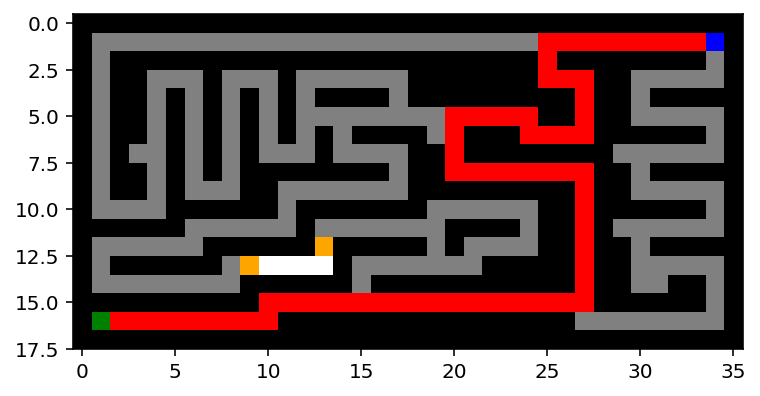

DFS:  medium_maze_2goals1.txt


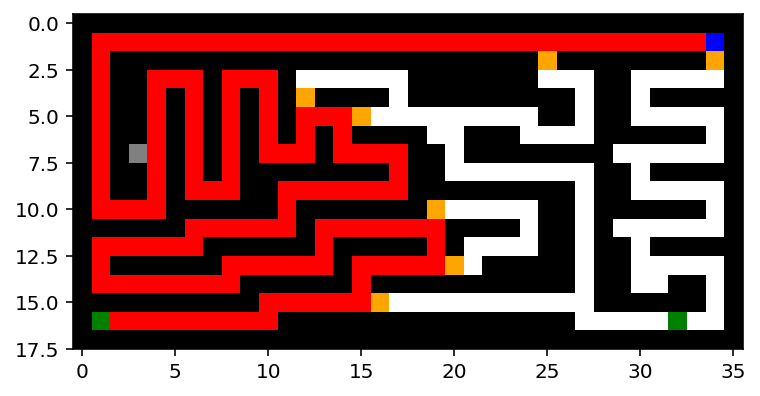

IDS:  medium_maze_2goals1.txt


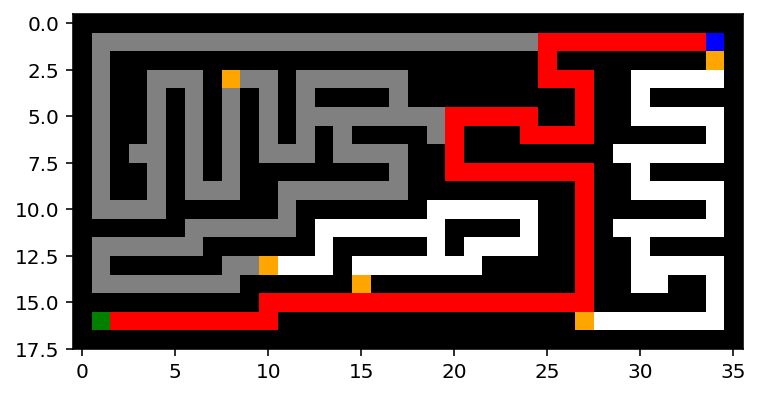

                    medium_maze_2goals1.txt Results
  Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  Max Tree  Max Frontier
0       BFS         69             266              69       137             9
1       DFS        153             152             139       578             8
2       IDS         69             189              55       100             7

 
 
 
 
BFS:  medium_maze_2goals2.txt


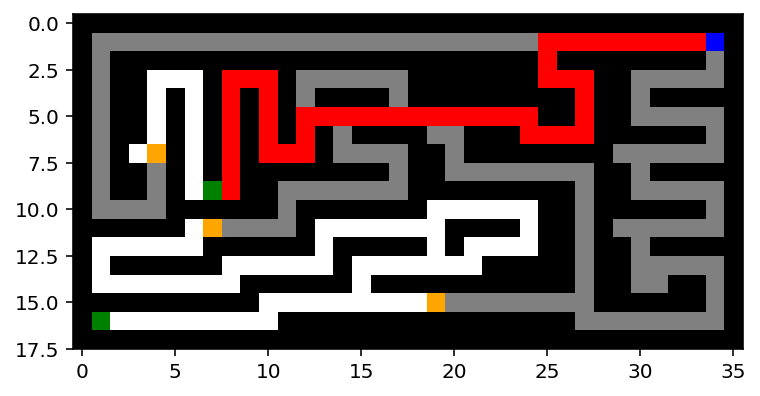

DFS:  medium_maze_2goals2.txt


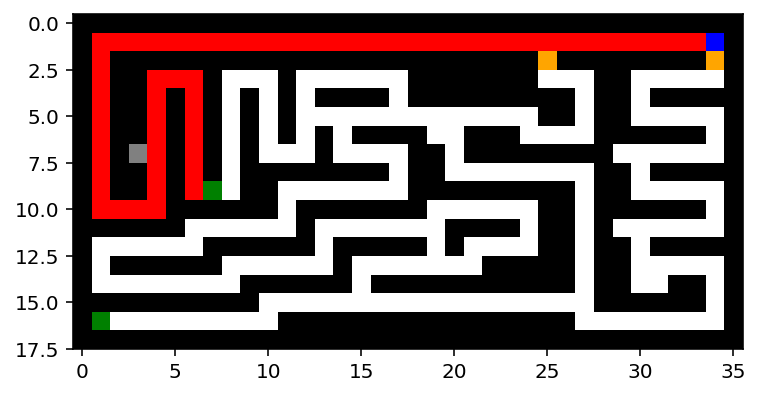

IDS:  medium_maze_2goals2.txt


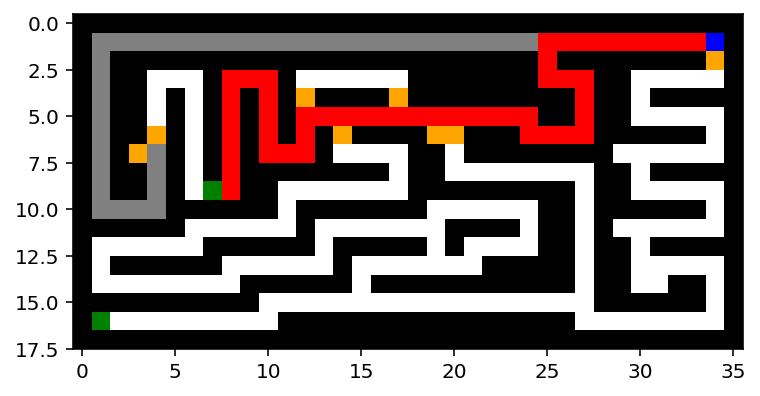

                    medium_maze_2goals2.txt Results
  Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  Max Tree  Max Frontier
0       BFS         50             187              50       149             9
1       DFS         62              61              11        13             4
2       IDS         50              87              34       150             7

 
 
 
 
BFS:  medium_maze_3goals1.txt


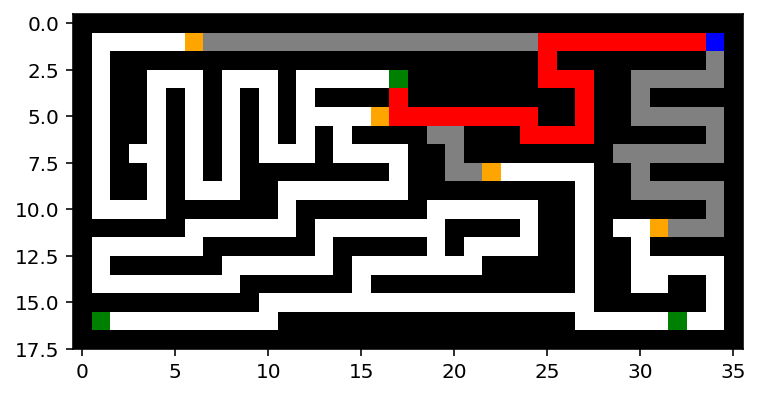

DFS:  medium_maze_3goals1.txt


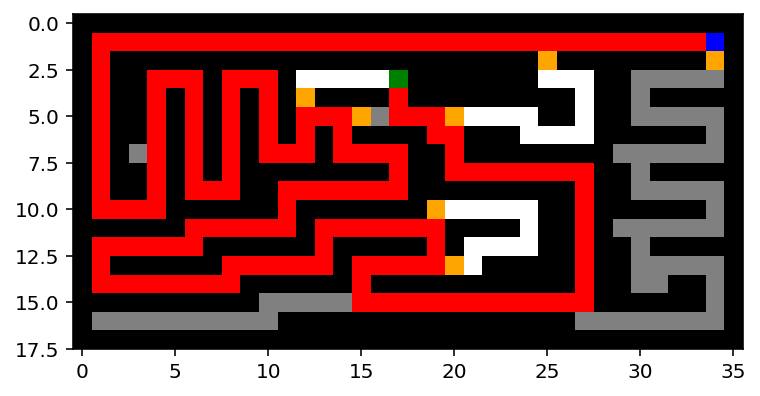

IDS:  medium_maze_3goals1.txt


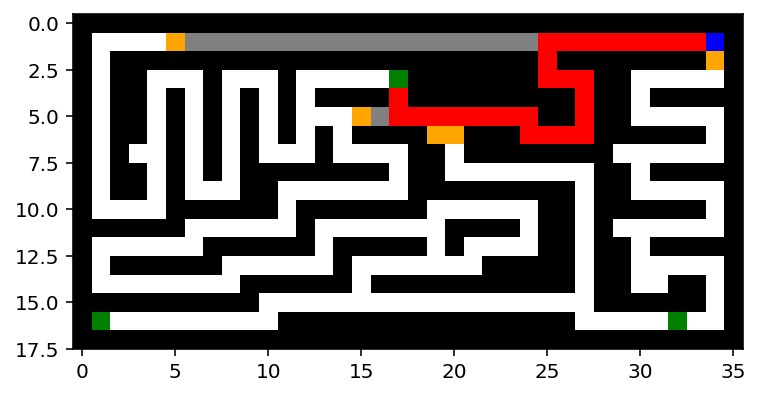

                    medium_maze_3goals1.txt Results
  Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  Max Tree  Max Frontier
0       BFS         30              80              30       118             5
1       DFS        172             236             167       606            10
2       IDS         30              48              27        55             5

 
 
 
 
BFS:  medium_maze_3goals1.txt


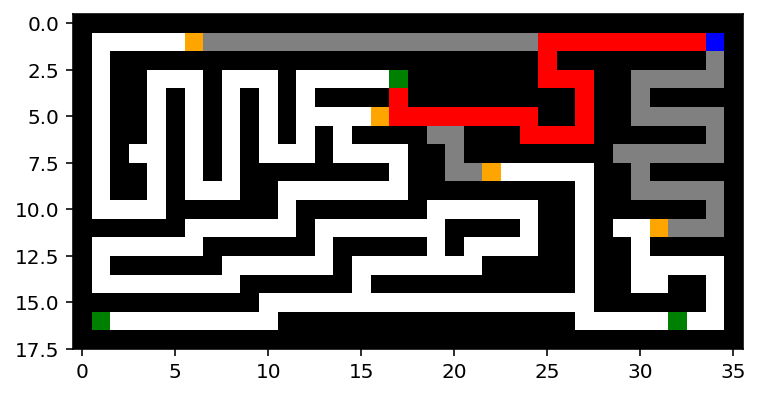

DFS:  medium_maze_3goals1.txt


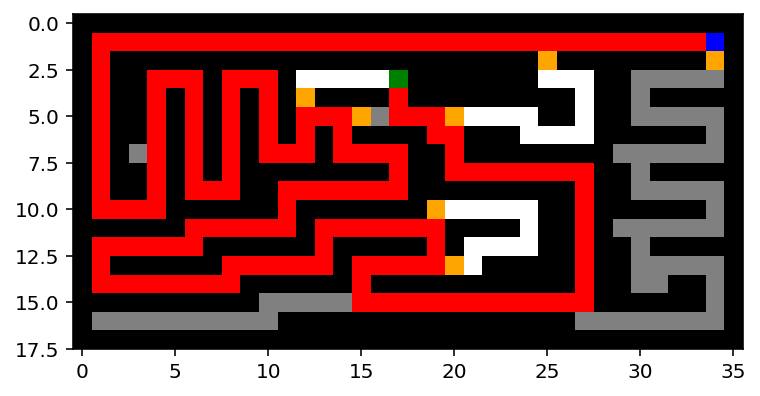

IDS:  medium_maze_3goals1.txt


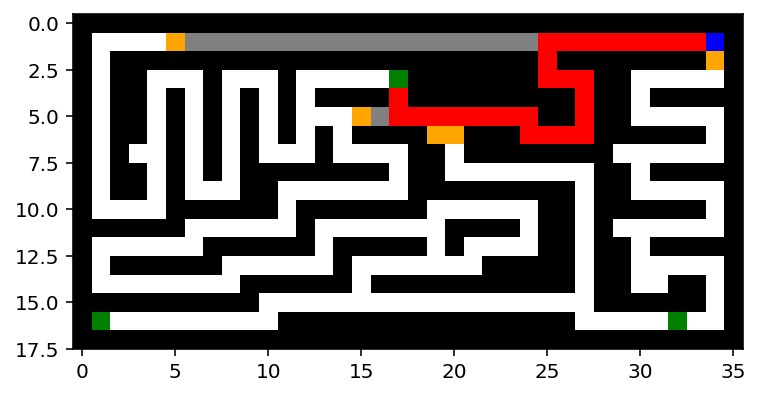

                    medium_maze_3goals1.txt Results
  Algorithm  Path Cost  Nodes Expanded  Max Tree Depth  Max Tree  Max Frontier
0       BFS         30              80              30       118             5
1       DFS        172             236             167       606            10
2       IDS         30              48              27        55             5

 
 
 
 


In [10]:
# Your code/answer goes here
# Iterative Depth Search
def IDS(maze, verbose):
    depth = 0
    start = find_pos(maze, what = "S")
    goal = find_pos(maze, what = "G")
    for depth in range(0, 100000):
        result = DLS(maze, depth, verbose)
        maze[start] = "S"
        maze[goal] = "G"
        if result != "Cutoff":
            return result
        
    return "failure"

def DLS(maze, depth, verbose):
    cleanMaze(maze)
    path_cost = 0;
    nodes_expanded = 0;
    max_tree_depth = 0;
    max_tree_size = 0;
    max_frontier = 0; 
    start = find_pos(maze, what = "S")
    goal = find_pos(maze, what = "G")
    root = Node(pos = find_pos(maze, what = "S"), parent = None, action = None, cost = 0, distance = 0)
    if (root.pos == find_pos(maze, what = "G")): return node
    frontier = []
    frontier.append(root)
    cycle = []
    result = "Failure"
   
    while(frontier):
        node = frontier.pop(len(frontier)-1)
        cycle = node.get_path_from_root()
        maze[start] = "S"
        maze[goal] = "G"
        if(verbose): PrintMaze(maze)  
            
        if (node.pos == goal):
            nodes_expanded = np.count_nonzero(maze == ".")
            path = child.get_path_from_root()
            for node in path:
                maze[node.pos[0], node.pos[1]] = "P"
                path_cost += 1
            tree = getMaxTreeDepthIDS(frontier)
            max_tree_depth = tree[0]
            max_tree_size = tree[1]
            maze[start] = "S"
            maze[goal] = "G"
            result = [path_cost, nodes_expanded, max_tree_depth, max_tree_size, max_frontier, node, maze]
            return result
    
        if DepthIDS(node) > depth:
            result = "Cutoff"
            
        elif (cycle.count(node) < 2):
            for child in ExpandIDS(maze, node):
                if(child.action != "D"):
                    frontier.append(child)
            
        if(len(frontier) > max_frontier): max_frontier = len(frontier)
        
    return result

            
           
def ExpandIDS(maze, node):
    pos = node.pos
    for action in ActionIDS(maze, pos):
        pos1 = ResultIDS(pos, action)
        cost = node.cost + ActionCostIDS(pos, action, pos1)
        maze[pos] = "."
        if(action != "D"):
            maze[pos1] = "F"
        else:
            maze[pos1] = "."
        yield Node(pos1, node, action, cost, distance = 0)
        
def ActionIDS(maze, pos):
    actions = []     
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if((look(maze, (row-1, col)) == " ") or (look(maze, (row-1, col)) == "G")): #north
        actions.append("N")
    if((look(maze, (row, col+1)) == " ") or (look(maze, (row, col+1)) == "G")): #east
        actions.append("E")
    if((look(maze, (row+1, col)) == " ") or (look(maze, (row+1, col)) == "G")): #south
        actions.append("S")
    if((look(maze, (row, col-1)) == " ") or (look(maze, (row, col-1)) == "G")): #west
        actions.append("W")
    if not actions: #List Empty
        actions.append("D")
    return actions

def ResultIDS(pos, action):
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if(action == "N"):
        return (row-1, (col))
    if(action == "E"):
        return (row, col+1)
    if(action == "S"):
        return (row+1, col)
    if(action == "W"):
        return (row, col-1)
    return pos

def ActionCostIDS(pos, action, pos1):
    return 1              

def getMaxTreeDepthIDS(frontier):
    max_tree_depth = 0
    max_tree_size = 0
    for node in frontier:
        path = node.get_path_from_root()
        if(len(path) > max_tree_depth):
            max_tree_depth = len(path)
        max_tree_size += len(node.get_path_from_root())
    return (max_tree_depth, max_tree_size)

def DepthIDS(node):
    path = node.get_path_from_root()
    depth = len(path)
    return depth

def cleanMaze(maze):
    maze[maze=="F"] = " "
    maze[maze=="."] = " "

#############################################################################################################################################################
#############################################################################################################################################################            
#Testing BFS/DFS/IDS on Medium Maze with multiple goals
import pandas as pd
mazes = ["medium_maze_2goals1.txt", "medium_maze_2goals2.txt", "medium_maze_3goals1.txt", "medium_maze_3goals1.txt"]

    
resultsBFS = []
resultsDFS = []
resultsIDS = []
verbose = False
for maze in mazes:
    f = open(maze, "r")
    maze_str = f.read()
    maze_master = parse_maze(maze_str)
    print("BFS: ", maze)
    maze_master = parse_maze(maze_str)
    resultsBFS = BFS(maze_master, verbose)
    PrintMaze(resultsBFS[6])
    print("DFS: ", maze)
    maze_master = parse_maze(maze_str)
    resultsDFS = DFS(maze_master, verbose)
    PrintMaze(resultsDFS[6])
    print("IDS: ", maze)
    maze_master = parse_maze(maze_str)
    resultsIDS = IDS(maze_master, verbose)
    PrintMaze(resultsIDS[6])

    data = [["BFS", resultsBFS[0], resultsBFS[1], resultsBFS[2], resultsBFS[3], resultsBFS[4]],
        ["DFS", resultsDFS[0], resultsDFS[1], resultsDFS[2], resultsDFS[3], resultsDFS[4]],
        ["IDS", resultsIDS[0], resultsIDS[1], resultsIDS[2], resultsIDS[3], resultsIDS[4]]]
    frame = pd.DataFrame(data, columns=["Algorithm", "Path Cost", "Nodes Expanded" ,"Max Tree Depth", "Max Tree", "Max Frontier"])
    print("                    " + maze + " Results")
    print(frame)
    print("\n \n \n \n ")

# Notes on BFS/DFS/IDS multiple Goals
DFS consistently preformed the worst as both BFS and IDS had a better chance of finding a goal. Both BFS and IDS spread out the search tree along multiple branches while DFS gambles by picking one. In this case, the multiple goals allowed BFS and IDS to find the goal state faster. 

## More advanced tasks to think about

Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

              BFS Medium Maze Intersection


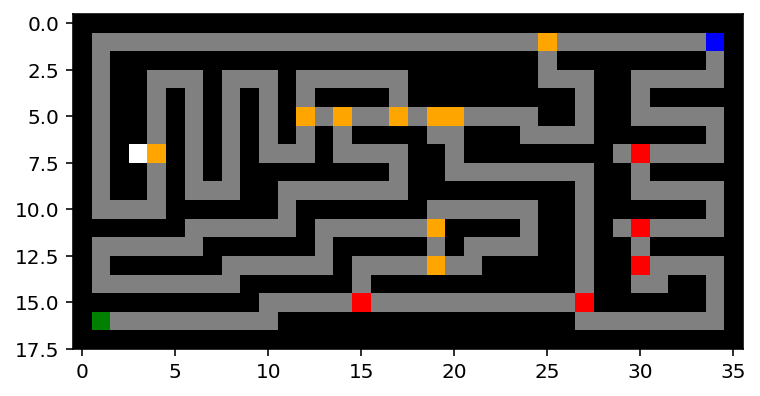

  Algorithm  Path Cost  Nodes Expanded
0       BFS         82             257

 
 
 
 


In [14]:
#Breadth First Search Modified For Intersections
def MazeMod(maze):
    for col in maze:
        for row in col:
            if(len(ActionsBFS(maze, [row, col])) > 1):
                maze[row, col] = "F"

def BFSmod(maze, verbose):
    path_cost = 0;
    nodes_expanded = 0;
    max_tree_depth = 0;
    max_tree_size = 0;
    max_frontier = 0; 
    start = find_pos(maze, what = "S")
    goal = find_pos(maze, what = "G")
    node = Node(pos = find_pos(maze, what = "S"), parent = None, action = None, cost = 0, distance = 0)
    if (node.pos == find_pos(maze, what = "G")): return node
    frontier = []
    reached = []
    reachedNodes = []
    frontier.append(node)
    
    while(frontier):
        n = frontier.pop(0)
        for child in ExpandBFSmod(maze, n, reachedNodes):
            maze[start] = "S"
            maze[goal] = "G"
            if(verbose): PrintMaze(maze)           
            if (child.pos == goal):
                nodes_expanded = np.count_nonzero(maze == ".")
                path = child.get_path_from_root()
                for node in path:
                    maze[node.pos[0], node.pos[1]] = "P"
                    path_cost += node.cost
                tree = getMaxTreeDepthBFSmod(frontier)
                max_tree_depth = tree[0]
                max_tree_size = tree[1]
                maze[start] = "S"
                maze[goal] = "G"
                print("              BFS Medium Maze Intersection")
                PrintMaze(maze)
                result = [path_cost, nodes_expanded, max_tree_depth, max_tree_size, max_frontier, child, maze]
                return result         
            if child.pos not in reached:
                reached.append(child.pos)
                reachedNodes.append(child)
                frontier.append(child)  
            if(len(frontier) > max_frontier): max_frontier = len(frontier)
    print("BFSmod Failure")
    return "Failure"
            
def ExpandBFSmod(maze, node, reachedNodes):
    pos = node.pos
    action = [1]
    pos1 = []
    cost = 0
    deadEndCount = 0
    while(True): #intersetcion
        action = ActionBFSmod(maze, pos)
        pos1 = ResultBFSmod(pos, action[0])
        cost += 1
        if(action.count("D") > 0):
            cost = 0
            pos = node.pos
            deadEndCount += 1
            if(deadEndCount >= 10):
                node = reachedNodes.pop(0)
                cost = 0
                pos = node.pos
            continue
        if(look(maze, pos) != "S"):
            if((len(ActionBFSmod(maze, pos1)) > 1) or (look(maze, pos1) == "G")):
                cost += 1
                maze[pos1] = "F"
                if(verbose): PrintMaze(maze) 
                yield Node(pos1, node, action[0], cost, distance = 0)
                break
        if(maze[pos1] != "F"): maze[pos1] = "."
        pos = pos1
        if(verbose): PrintMaze(maze) 
        


        
def ActionBFSmod(maze, pos):
    import random
    actions = []     
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if((look(maze, (row-1, col)) == " ") or (look(maze, (row-1, col)) == "G")): #north
        actions.append("N")
    if((look(maze, (row, col+1)) == " ") or (look(maze, (row, col+1)) == "G")): #east
        actions.append("E")
    if((look(maze, (row+1, col)) == " ") or (look(maze, (row+1, col)) == "G")): #south
        actions.append("S")
    if((look(maze, (row, col-1)) == " ") or (look(maze, (row, col-1)) == "G")): #west
        actions.append("W")
    if not actions: #List Empty
        actions.append("D")
    random.shuffle(actions)  
    return actions

def ResultBFSmod(pos, action):
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if(action == "N"):
        return (row-1, (col))
    if(action == "E"):
        return (row, col+1)
    if(action == "S"):
        return (row+1, col)
    if(action == "W"):
        return (row, col-1)
    return pos

def ActionCostBFSmod(pos, action, pos1):
    return 1              

def getMaxTreeDepthBFSmod(frontier):
    max_tree_depth = 0
    max_tree_size = 0
    for node in frontier:
        path = node.get_path_from_root()
        if(len(path) > max_tree_depth):
            max_tree_depth = len(path)
        max_tree_size += len(node.get_path_from_root())
    return (max_tree_depth, max_tree_size)


#############################################################################################################################################################
#############################################################################################################################################################
# Iterative Depth Search Modified For Intersections
def IDSmod(maze, verbose):
    depth = 0
    start = find_pos(maze, what = "S")
    goal = find_pos(maze, what = "G")
    for depth in range(0, 100000):
        result = DLS(maze, depth, verbose)
        maze[start] = "S"
        maze[goal] = "G"
        if result != "Cutoff":
            return result
        
    return "failure"

def DLS(maze, depth, verbose):
    cleanMazeIDSmod(maze)
    path_cost = 0;
    nodes_expanded = 0;
    max_tree_depth = 0;
    max_tree_size = 0;
    max_frontier = 0; 
    start = find_pos(maze, what = "S")
    goal = find_pos(maze, what = "G")
    root = Node(pos = find_pos(maze, what = "S"), parent = None, action = None, cost = 0, distance = 0)
    if (root.pos == find_pos(maze, what = "G")): return node
    frontier = []
    frontier.append(root)
    cycle = []
    result = "Failure"
   
    while(frontier):
        node = frontier.pop(len(frontier)-1)
        cycle = node.get_path_from_root()
        maze[start] = "S"
        maze[goal] = "G"
        if(verbose): PrintMaze(maze)  
            
        if (node.pos == goal):
            nodes_expanded = np.count_nonzero(maze == ".")
            tree = getMaxTreeDepthIDSmod(frontier)
            max_tree_depth = tree[0]
            max_tree_size = tree[1]
            for node in path:
                maze[node.pos[0], node.pos[1]] = "P"
                path_cost += 1
            max_tree_depth = getMaxTreeDepthIDS(frontier)
            maze[start] = "S"
            maze[goal] = "G"
            result = [path_cost, nodes_expanded, max_tree_depth, max_tree_size, max_frontier, node, maze]
            return result
    
        if DepthIDS(node) > depth:
            result = "Cutoff"
            
        elif (cycle.count(node) < 2):
            for child in ExpandIDS(maze, node):
                if(child.action != "D"):
                    frontier.append(child)
            
        if(len(frontier) > max_frontier): max_frontier = len(frontier)
        
    return result

            
           
def ExpandIDSmod(maze, node, reachedNodes):
    pos = node.pos
    action = [1]
    pos1 = []
    cost = 0
    deadEndCount = 0
    while(True): #intersetcion
        action = ActionIDSmod(maze, pos)
        pos1 = ResultIDSmod(pos, action[0])
        cost += 1
        if(action.count("D") > 0):
            cost = 0
            pos = node.pos
            deadEndCount += 1
            if(deadEndCount >= 10):
                node = reachedNodes.pop(0)
                cost = node.cost
                pos = node.pos
            continue
        if(look(maze, pos) != "S"):
            if((len(ActionIDSmod(maze, pos1)) > 1) or (look(maze, pos1) == "G")):
                cost += 1
                maze[pos1] = "F"
                if(verbose): PrintMaze(maze) 
                yield Node(pos1, node, action[0], cost, distance = 0)
                break
        if(maze[pos1] != "F"): maze[pos1] = "."
        pos = pos1
        if(verbose): PrintMaze(maze) 
        
def ActionIDSmod(maze, pos):
    actions = []     
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if((look(maze, (row-1, col)) == " ") or (look(maze, (row-1, col)) == "G")): #north
        actions.append("N")
    if((look(maze, (row, col+1)) == " ") or (look(maze, (row, col+1)) == "G")): #east
        actions.append("E")
    if((look(maze, (row+1, col)) == " ") or (look(maze, (row+1, col)) == "G")): #south
        actions.append("S")
    if((look(maze, (row, col-1)) == " ") or (look(maze, (row, col-1)) == "G")): #west
        actions.append("W")
    if not actions: #List Empty
        actions.append("D")
    return actions

def ResultIDSmod(pos, action):
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if(action == "N"):
        return (row-1, (col))
    if(action == "E"):
        return (row, col+1)
    if(action == "S"):
        return (row+1, col)
    if(action == "W"):
        return (row, col-1)
    return pos

def ActionCostIDSmod(pos, action, pos1):
    return 1              

def getMaxTreeDepthIDSmod(frontier):
    max_tree_depth = 0
    max_tree_size = 0
    for node in frontier:
        path = node.get_path_from_root()
        if(len(path) > max_tree_depth):
            max_tree_depth = len(path)
        max_tree_size += len(node.get_path_from_root())
    return (max_tree_depth, max_tree_size)

def DepthIDSmod(node):
    path = node.get_path_from_root()
    depth = len(path)
    return depth

def cleanMazeIDSmod(maze):
    maze[maze=="F"] = " "
    maze[maze=="."] = " "

#############################################################################################################################################################
#############################################################################################################################################################
#Display BFS/IDS Intersection Results search results
    
ClearPrint()
f = open("medium_maze.txt", "r")
maze_str = f.read()
maze = parse_maze(maze_str)
master_maze = maze
verbose = False
resultsBFS = BFSmod(master_maze, verbose)
resultsIDS = IDSmod(master_maze, verbose)
data = [["BFS", resultsBFS[0], resultsBFS[1]]]
frame = pd.DataFrame(data, columns=["Algorithm", "Path Cost", "Nodes Expanded"])
print(frame)
print("\n \n \n \n ")

# BFS/IDS Intersection Discussion
I modified the expand function to check if nodes have more than one action available to them. If they did, it meant they were an intersection. If the node only had one action, it was iterated inside the expand function without adding to the tree. If the path ran into a dead end, the previous node was pulled from a list of previous nodes and allowed to choose a different action. The path cost was reset to the previous node. In the figure above, the red tiles are the intersections the algorithm choose as the optimal path. I ran into many issues implementing this but finally got it to work. The .GIF file of this is very fun to watch. 
* Issues with running into dead ends
    Need to return to previous intersection and pick a new action and reset path cost
* Issues with running into other intersections which blocked the path.
    Needed to add exception to available actions selector
* Issues with Intersections running into each other and not seeing each other


Modify your A* search to add weights (see text book) and explore how different weights influence the result.

AstarW(1):  open_maze.txt


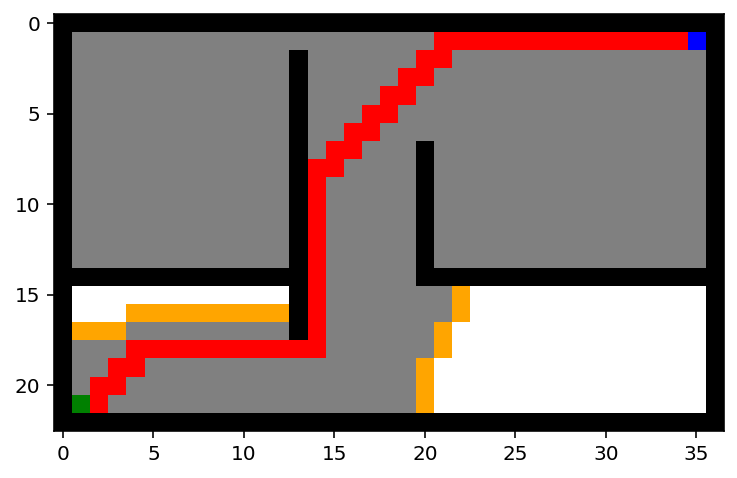

AstarW(5):  open_maze.txt


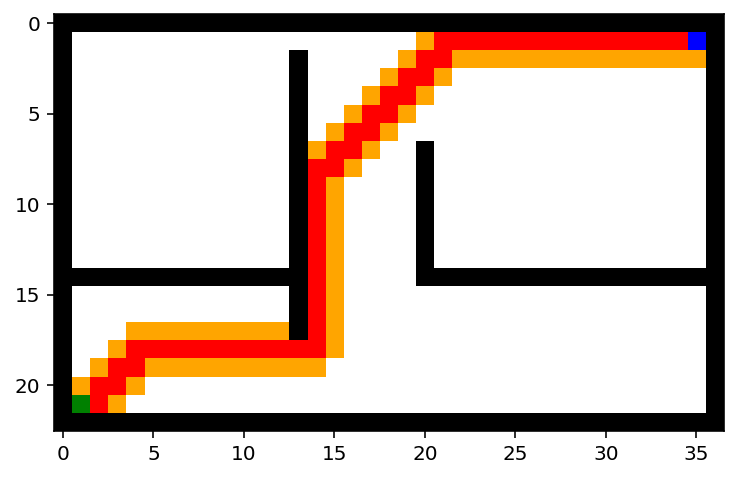

AstarW(10):  open_maze.txt


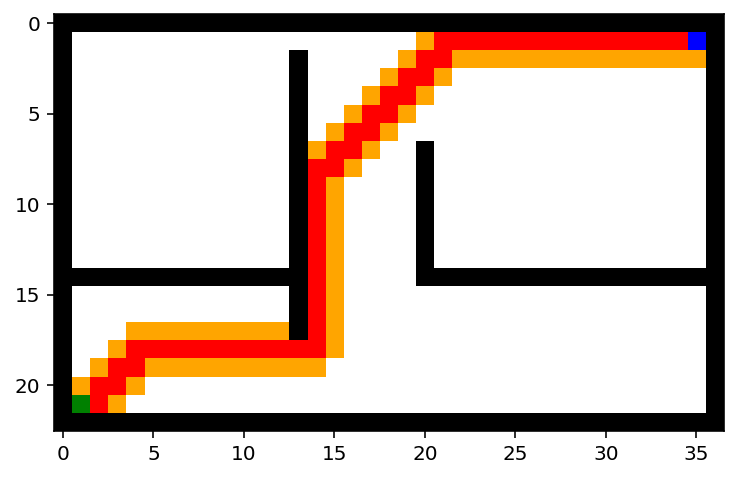

AstarW(100):  open_maze.txt


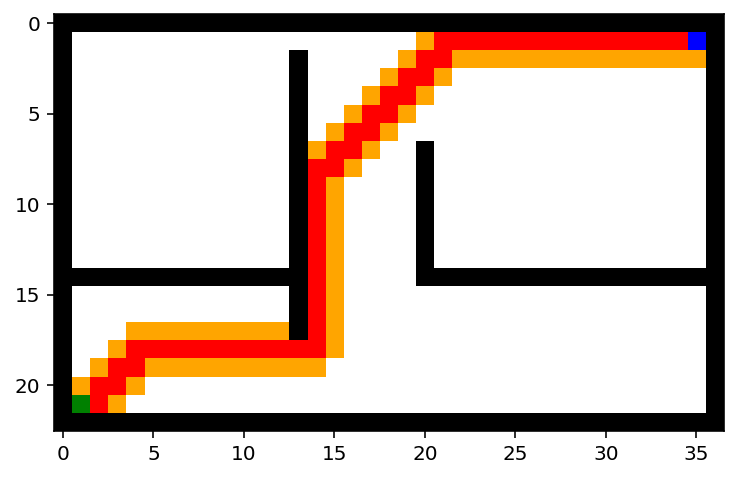

AstarW(.1):  open_maze.txt


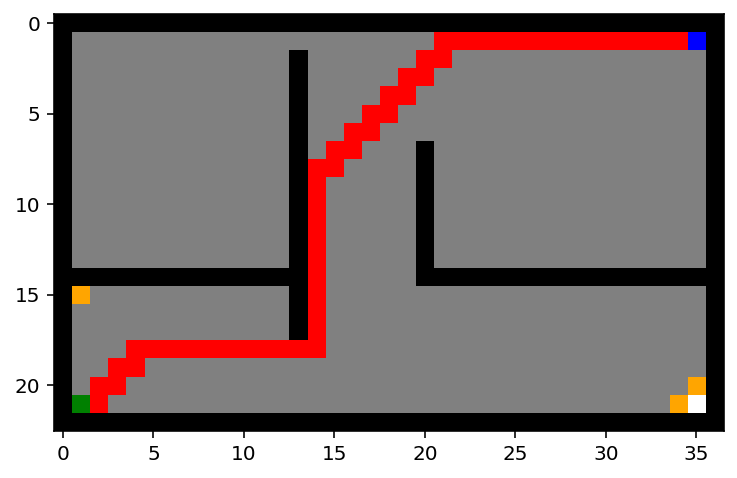

                    open_maze.txt Results
        A*  Path Cost  Nodes Expanded  Max Tree Depth  Max Tree  Max Frontier
0    W = 1         55             570              55       885            51
1    W = 5         55             115              54      1877            62
2   W = 10         55             115              54      1877            62
3  W = 100         55             115              54      1877            62
4   W = .1         55             683              55       214            24

 
 
 
 
AstarW(1):  small_maze.txt


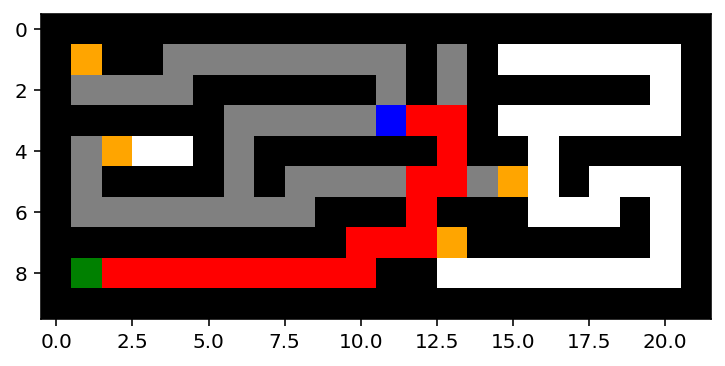

AstarW(5):  small_maze.txt


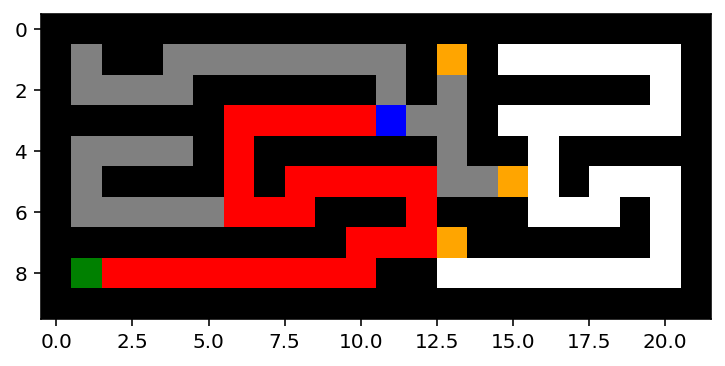

AstarW(10):  small_maze.txt


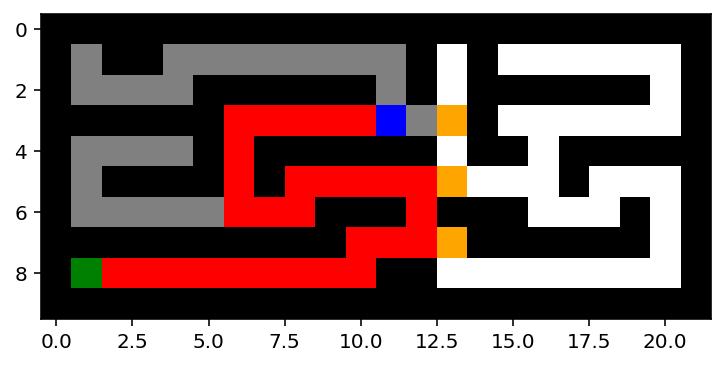

AstarW(100):  small_maze.txt


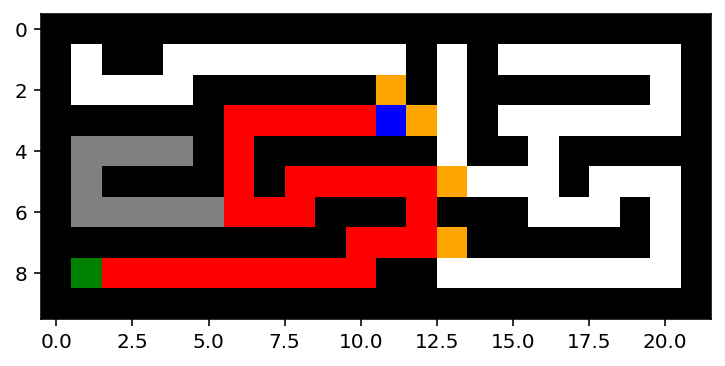

AstarW(.1):  small_maze.txt


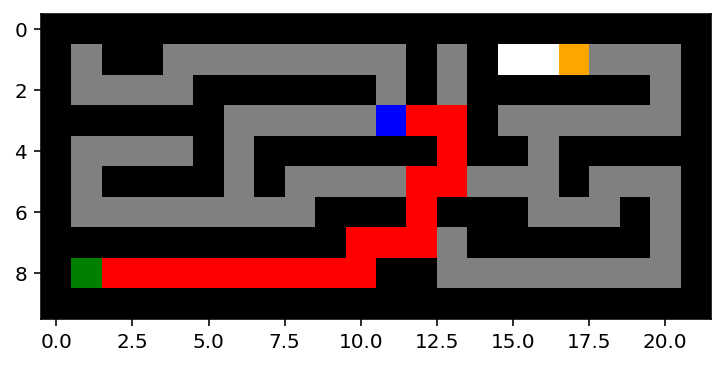

                    small_maze.txt Results
        A*  Path Cost  Nodes Expanded  Max Tree Depth  Max Tree  Max Frontier
0    W = 1         20              60              17        48             7
1    W = 5         30              62              19        31             4
2   W = 10         30              57              19        39             4
3  W = 100         30              43              19        40             5
4   W = .1         20              91              19        19             8

 
 
 
 
AstarW(1):  medium_maze.txt


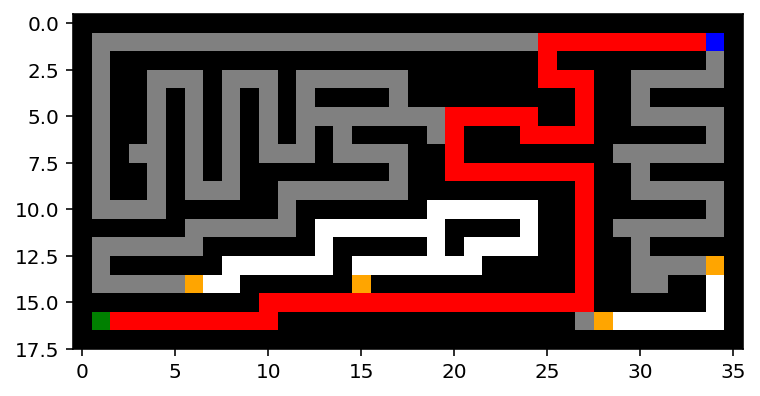

AstarW(5):  medium_maze.txt


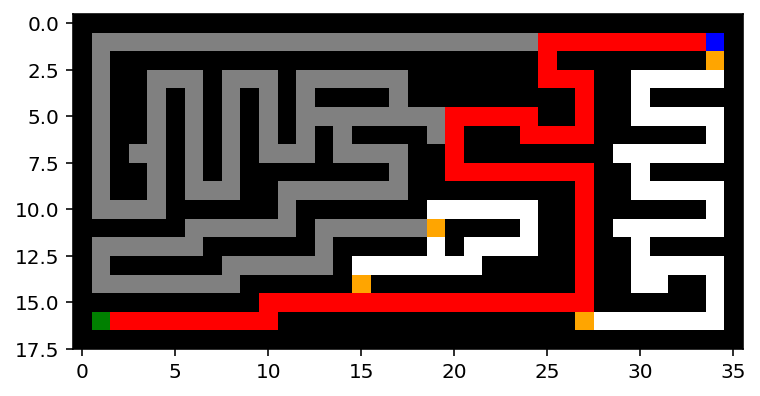

AstarW(10):  medium_maze.txt


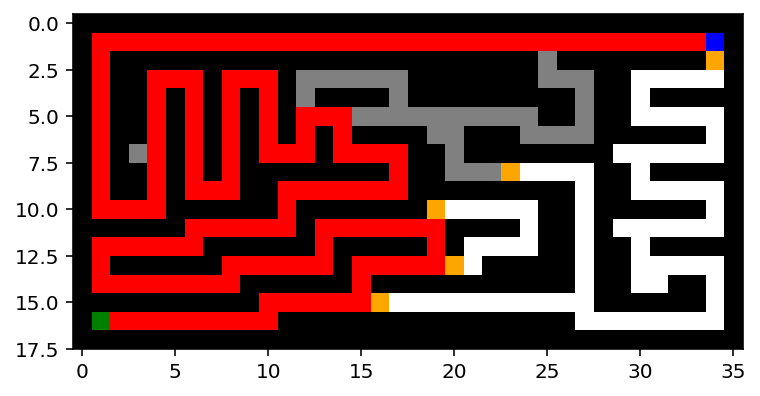

AstarW(100):  medium_maze.txt


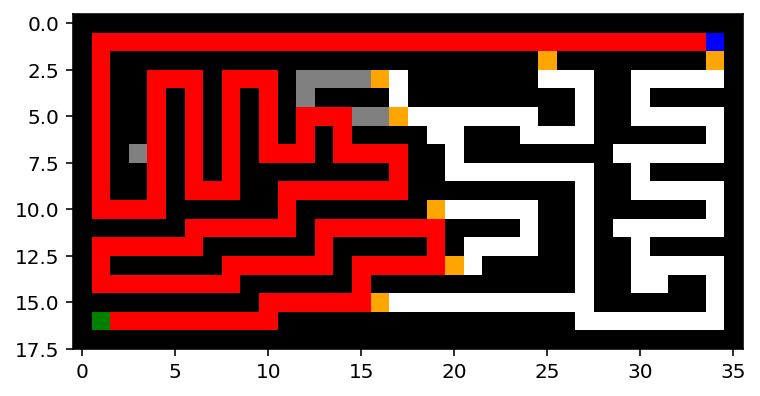

AstarW(.1):  medium_maze.txt


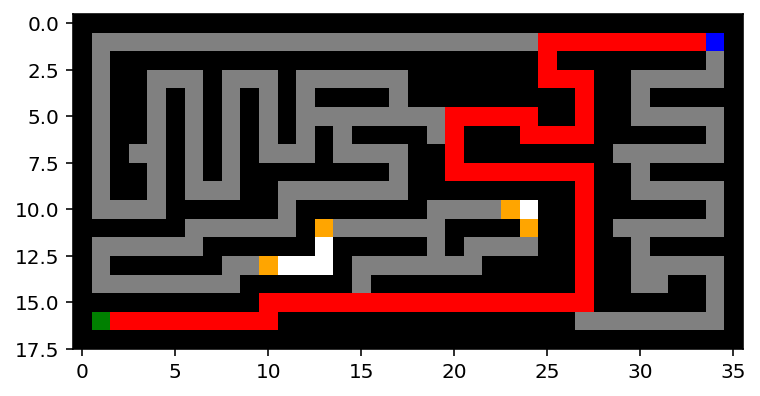

                    medium_maze.txt Results
        A*  Path Cost  Nodes Expanded  Max Tree Depth  Max Tree  Max Frontier
0    W = 1         69             230              64       200             8
1    W = 5         69             206              80       180             7
2   W = 10        153             192             139       498             6
3  W = 100        153             167             139       585             8
4   W = .1         69             268              69       271             8

 
 
 
 
AstarW(1):  large_maze.txt


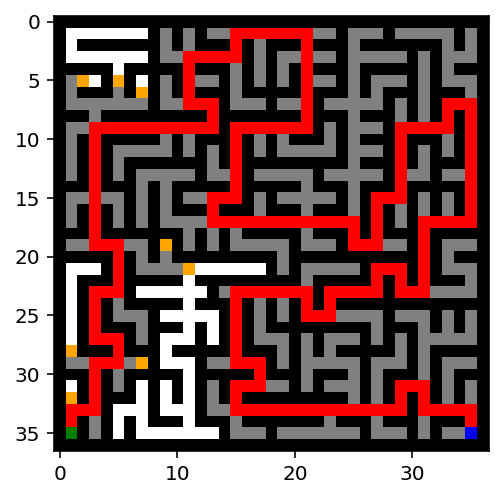

AstarW(5):  large_maze.txt


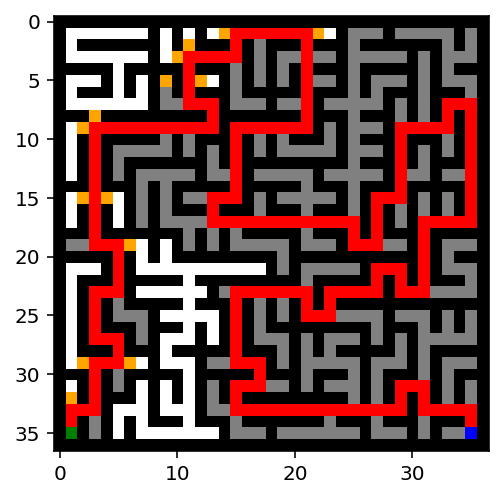

AstarW(10):  large_maze.txt


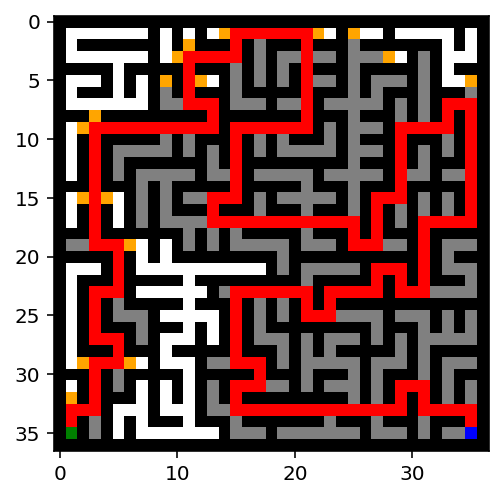

AstarW(100):  large_maze.txt


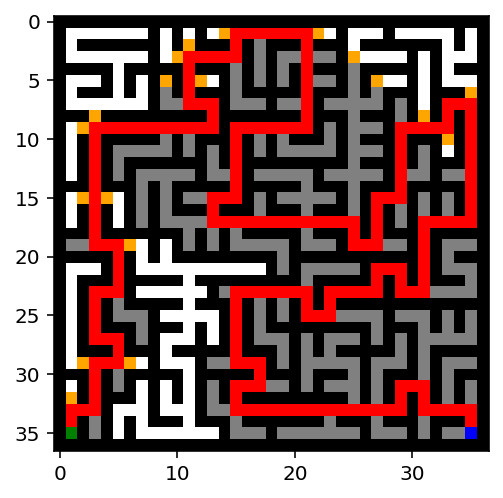

AstarW(.1):  large_maze.txt


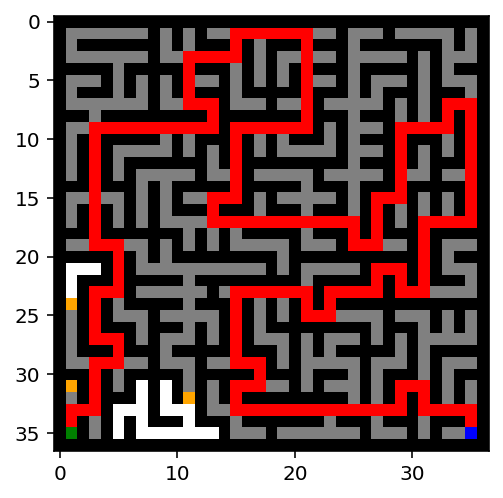

                    large_maze.txt Results
        A*  Path Cost  Nodes Expanded  Max Tree Depth  Max Tree  Max Frontier
0    W = 1        211             565             210      1554            10
1    W = 5        211             522             210      2459            15
2   W = 10        211             505             210      2797            18
3  W = 100        211             491             210      2973            20
4   W = .1        211             620             211       631             8

 
 
 
 


In [12]:
#############################################################################################################################################################
#############################################################################################################################################################
#A* Weighted Search
def AstarW(maze, verbose, weight):
    path_cost = 0;
    nodes_expanded = 0;
    max_tree_depth = 0;
    max_tree_size = 0;
    max_frontier = 0; 
    start = find_pos(maze, what = "S")
    goal = find_pos(maze, what = "G")
    node = Node(pos = find_pos(maze, what = "S"), parent = None, action = None, cost = 0, distance = 0)
    if (node.pos == find_pos(maze, what = "G")): return node
    frontier = []
    reached = []
    frontier.append(node)
    reached = {start : node}
    
    while(frontier):
        EuclideanDistanceAW(frontier, start, goal, weight)
        frontier.sort(key=DistanceAW)
        n = frontier.pop(0)
        if (n.pos == goal):
            path = n.get_path_from_root()
            for node in path:
                maze[node.pos[0], node.pos[1]] = "P"
                path_cost += 1
            tree = getMaxTreeDepthAW(frontier)
            max_tree_depth = tree[0]
            max_tree_size = tree[1]            
            maze[start] = "S"
            maze[goal] = "G"
            PrintMaze(maze)
            result = [path_cost, nodes_expanded, max_tree_depth, max_tree_size, max_frontier, n, maze]
            return result
        
        for child in ExpandAW(maze, n):
            maze[start] = "S"
            maze[goal] = "G"
            if(verbose): PrintMaze(maze)  
            pos = child.pos
            if ((pos not in reached) or (child.distance < reached[pos].distance) and (child.action != "D")):
                reached[pos] = child
                frontier.append(child)
                nodes_expanded += 1
  
            if(len(frontier) > max_frontier): max_frontier = len(frontier)

    print("BFS failure")
    return 0           

def ExpandAW(maze, node):
    pos = node.pos
    for action in ActionAW(maze, pos):
        pos1 = ResultAW(pos, action)
        cost = node.cost + ActionCostAW(pos, action, pos1)
        maze[pos] = "."
        if(action != "D"):
            maze[pos1] = "F"
        else:
            maze[pos1] = "."
        yield Node(pos1, node, action, cost, 0)
        
def ActionAW(maze, pos):
    actions = []     
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if((look(maze, (row-1, col)) == " ") or (look(maze, (row-1, col)) == "G")): #north
        actions.append("N")
    if((look(maze, (row, col+1)) == " ") or (look(maze, (row, col+1)) == "G")): #east
        actions.append("E")
    if((look(maze, (row+1, col)) == " ") or (look(maze, (row+1, col)) == "G")): #south
        actions.append("S")
    if((look(maze, (row, col-1)) == " ") or (look(maze, (row, col-1)) == "G")): #west
        actions.append("W")
    if not actions: #List Empty
        actions.append("D")
    return actions

def ResultAW(pos, action):
    temp = list(pos)
    row = temp[0]
    col = temp[1]
    if(action == "N"):
        return (row-1, (col))
    if(action == "E"):
        return (row, col+1)
    if(action == "S"):
        return (row+1, col)
    if(action == "W"):
        return (row, col-1)
    return pos

def ActionCostAW(pos, action, pos1):
    return 1              

def getMaxTreeDepthAW(frontier):
    max_tree_depth = 0
    max_tree_size = 0
    for node in frontier:
        path = node.get_path_from_root()
        if(len(path) > max_tree_depth):
            max_tree_depth = len(path)
        max_tree_size += len(node.get_path_from_root())
    return (max_tree_depth, max_tree_size)

def EuclideanDistanceAW(frontier, start, goal, weight):
    import math
    tempG = list(goal)
    rowG = tempG[0]
    colG = tempG[1]
    for node in frontier:
        dStart = 0
        dGoal = 0
        path = node.get_path_from_root()
        for node in path:
            dStart += 1
        tempG = list(node.pos)
        row = tempG[0]
        col = tempG[1]
        dGoal = math.hypot((rowG - row),(colG - col))    
        node.distance = dStart + dGoal*weight

def DistanceAW(d):
    return d.distance

#############################################################################################################################################################
#############################################################################################################################################################
#Display A*weighted search results
import pandas as pd
mazes = ["open_maze.txt", "small_maze.txt", "medium_maze.txt", "large_maze.txt"]
    
resultsAW1 = []
resultsAW5 = []
resultsAW10 = []
resultsAW05 = []
resultsAW010 = []
for maze in mazes:
    verbose = False
    f = open(maze, "r")
    maze_str = f.read()
    maze_master = parse_maze(maze_str)
    print("AstarW(1): ", maze)
    maze_master = parse_maze(maze_str)
    resultsAW1 = AstarW(maze_master, verbose, 1)
    print("AstarW(5): ", maze)
    maze_master = parse_maze(maze_str)
    resultsAW5 = AstarW(maze_master, verbose, 5)
    print("AstarW(10): ", maze)
    maze_master = parse_maze(maze_str)
    resultsAW10 = AstarW(maze_master, verbose, 10)
    print("AstarW(100): ", maze)
    maze_master = parse_maze(maze_str)
    resultsAW05 = AstarW(maze_master, verbose, 100)
    print("AstarW(.1): ", maze)
    maze_master = parse_maze(maze_str)
    resultsAW010 = AstarW(maze_master, verbose, .1)
    data = [["W = 1", resultsAW1[0], resultsAW1[1], resultsAW1[2], resultsAW1[3], resultsAW1[4]],
        ["W = 5", resultsAW5[0], resultsAW5[1], resultsAW5[2], resultsAW5[3], resultsAW5[4]],
        ["W = 10", resultsAW10[0], resultsAW10[1], resultsAW10[2], resultsAW10[3], resultsAW10[4]],
        ["W = 100", resultsAW05[0], resultsAW05[1], resultsAW05[2], resultsAW05[3], resultsAW05[4]],
        ["W = .1", resultsAW010[0], resultsAW010[1], resultsAW010[2], resultsAW010[3], resultsAW010[4]]]
    frame = pd.DataFrame(data, columns=["A*", "Path Cost", "Nodes Expanded" ,"Max Tree Depth", "Max Tree", "Max Frontier"])
    print("                    " + maze + " Results")
    print(frame)
    print("\n \n \n \n ")

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

If the agent does not know the environment or can only see part of it, then all of the algorithms are basically uniformed search algorithms. Even A* and Greedy best first algorithm would have no heuristic function leaving them blind. Their performance would be equal to all of the others. If a GPS was added, this would allow the informed search algorithms (A* and GBFS) to function normally. In addition, some sort of sensor would need to be added like bumpers or distance to wall sensors. 
* Performance Measure: Would be path size compared to optimal path
* Environment: Static spaces with walls that cannot be crossed
* Actuator: Moving to adjacent tile
* Sensor: Could be bumpers, or even better distance to wall sensors. The distance sensors could return an int representing the length between the agent and the next wall in a ceratain direction. This would be helpful in intersections and for mapping when only part of the environment is visible. 

In [4]:
pip install nbconvert

jupyter nbconvert --to html notebook.ipynb  


SyntaxError: invalid syntax (2022812339.py, line 1)